In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx

from spicy_snow.retrieval import retrieval_from_parameters

In [2]:
data_fp = Path('~/scratch/spicy/SnowEx-Data').expanduser()
param_fp = Path('/bsuhome/zacharykeskinen/spicy-analysis/results/params/stat_res_0.5tree.csv')
param_df = pd.read_csv(param_fp, index_col = 0)

In [3]:
dss = {fp.stem:xr.open_dataset(fp) for fp in data_fp.glob('*')}

In [4]:
param_dss = {}
for loc, ds in dss.items():
    a, b, c = list(param_df.loc[loc, ['A', 'B', 'C']])
    ds = retrieval_from_parameters(ds.load(), a, b, c)
    ds.x.attrs['long_name'] = 'Longitude'
    ds.x.attrs['units'] = '°'
    ds.y.attrs['long_name'] = 'Latitude'
    ds.y.attrs['units'] = '°'
    for var in ds.data_vars:
        ds[var] = ds[var].rio.write_nodata(np.nan)
        ds[var] = ds[var].rio.write_crs('EPSG:4326')
    param_dss[loc] = ds

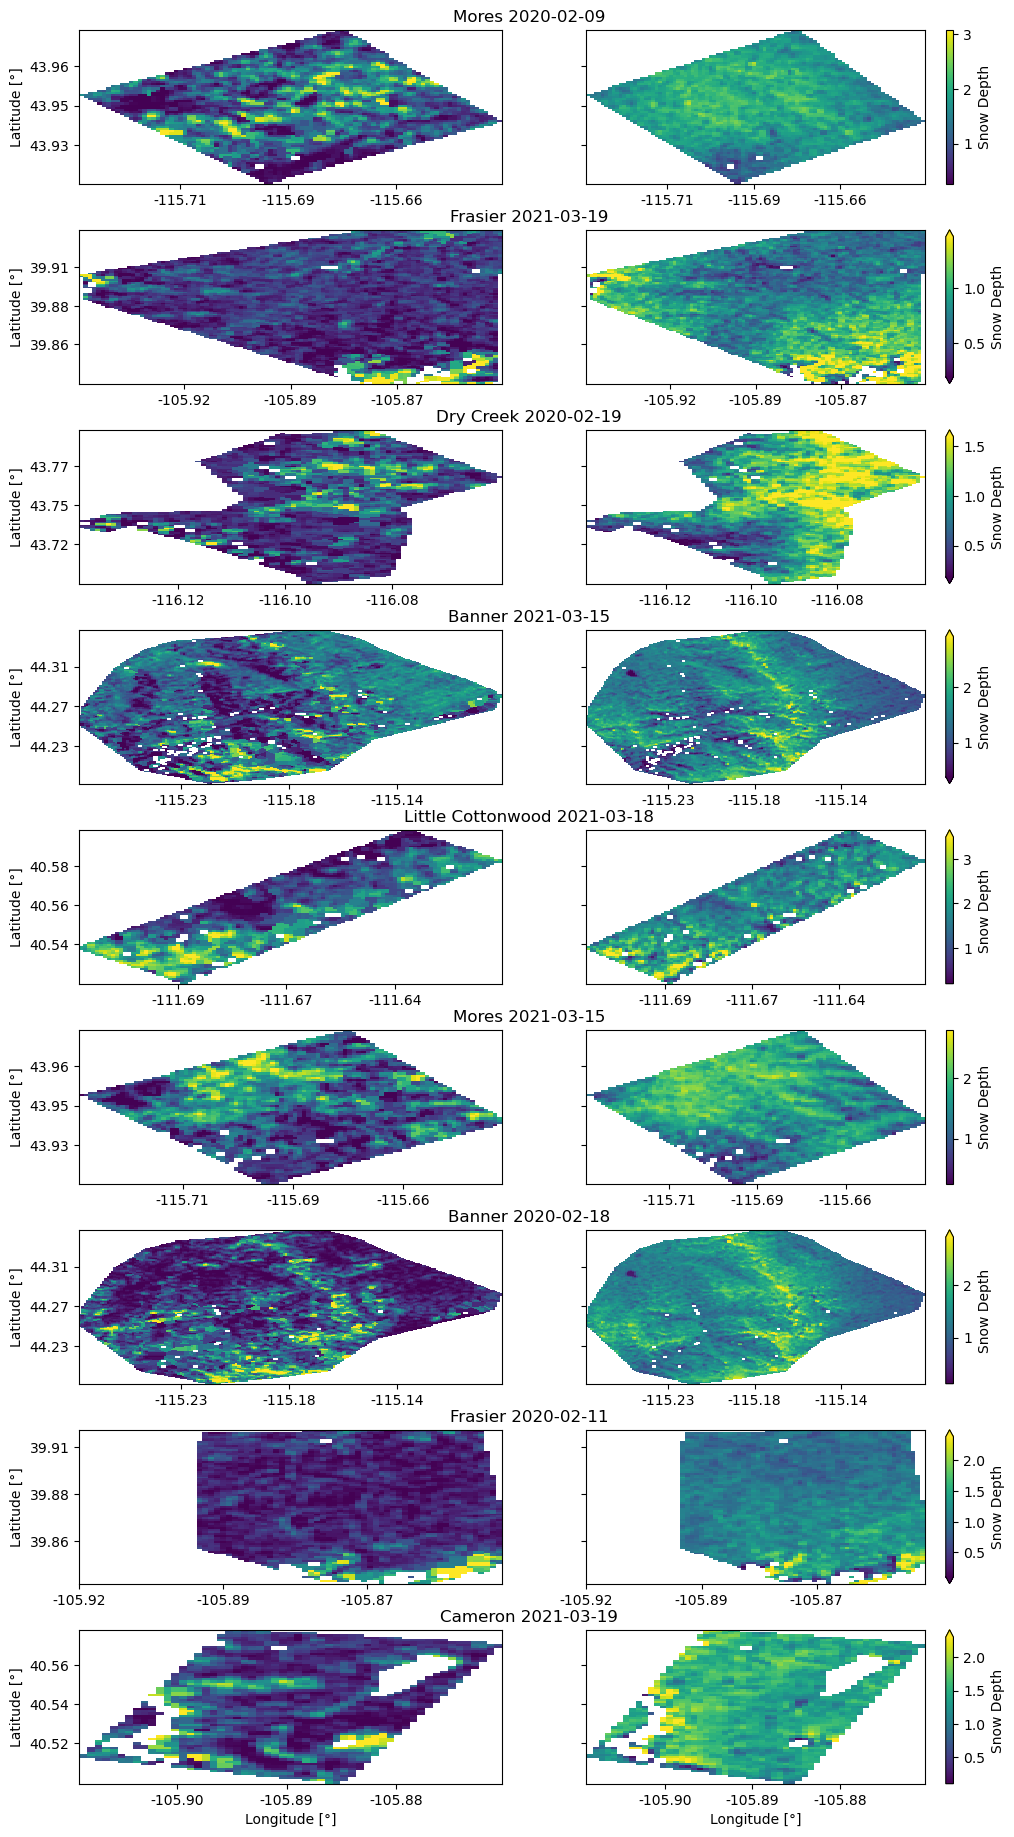

In [5]:
fig = plt.figure(figsize = (12, 18))
subfigs = fig.subfigures(len(param_dss)) # , wspace=0.07

for (loc, ds), subfig in zip(param_dss.items(), subfigs):
    
    axes = subfig.subplots(1, 2, sharey = True, sharex = True)

    ds = ds.sel(time = ~ds['snow_depth'].mean(['x', 'y']).isnull())

    ds = ds.rolling(x=2).mean()
    ds = ds.rolling(y=2).mean()

    spicy_sd = ds['snow_depth'].sel(time = ds.attrs['lidar-flight-time'], method = 'nearest')

    spicy_sd = spicy_sd.rio.interpolate_na()
    spicy_sd = spicy_sd.where(~ds['lidar-sd'].isnull())

    vmin, vmax = spicy_sd.quantile([0.05, 0.99])
    spicy_sd.x.attrs = ds.x.attrs
    spicy_sd.y.attrs = ds.y.attrs

    spicy_sd = spicy_sd.dropna(dim = 'x', how = 'all')
    spicy_sd = spicy_sd.dropna(dim = 'y', how = 'all')

    spicy_sd.plot(ax = axes[0], vmin = vmin, vmax = vmax, add_colorbar=False)
    
    ds['lidar-sd'].where(~spicy_sd.isnull()).plot(ax = axes[1], vmin = vmin, vmax = vmax, cbar_kwargs = {'label': 'Snow Depth'})

    for ax in axes:
        ax.set_title('')
        xticks = [ds.x.quantile(i).data for i in [0.25, 0.5, 0.75]]
        xlabs = [f"{x:.2f}" for x in xticks]
        ax.set_xticks(xticks, xlabs)

        xticks = [ds.y.quantile(i).data for i in [0.25, 0.5, 0.75]]
        xlabs = [f"{x:.2f}" for x in xticks]
        ax.set_yticks(xticks, xlabs)

    axes[1].set_ylabel('')

    plt.locator_params(axis='both', nbins=4)

    subfig.suptitle(loc.replace('_', ' '))
# plt.tight_layout()
# plt.savefig('/bsuhome/zacharykeskinen/spicy-analysis/results/test.png')

In [6]:
from geogif import gif, dgif

gif_dir = Path('/bsuhome/zacharykeskinen/spicy-analysis/figures/gifs/')

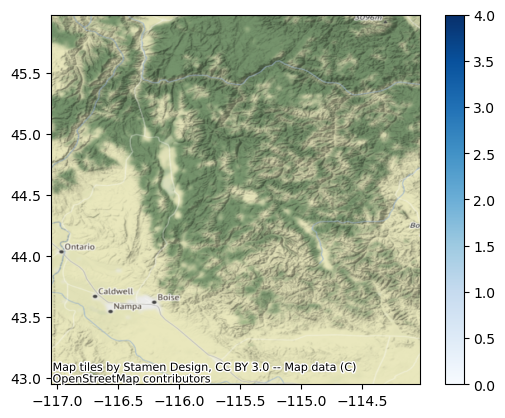

In [7]:
ds_q = xr.open_dataset('/bsuhome/zacharykeskinen/scratch/data/spicy-lowman-quadrant/combo_v3.nc')

from shapely.geometry import box
fig, ax = plt.subplots()
box(*ds_q.rio.bounds())

ds_q.isel(time = 0, x = slice(0, -1, 100), y = slice(0, -1, 100))['snow_depth'].plot(ax = ax, alpha = 0, add_colorbar = False)
im = plt.imshow([[1,1],[1,1]], vmax = 4, vmin = 0, cmap = 'Blues')
plt.colorbar(im)
ctx.add_basemap(ax = ax, crs = 'EPSG:4326')
plt.title('')
plt.xlabel('')
plt.ylabel('')

plt.savefig(gif_dir.joinpath('idaho_map.png'))

gif(ds_q['snow_depth'].transpose('time','y','x').isel(y=slice(None, None, -1)).isel(x = slice(0, -1, 4), y = slice(0, -1 ,4)), fps = 4, cmap = 'Blues', vmin = 0, vmax = 4, to = gif_dir.joinpath('quad.gif')) # to = gif_dir.joinpath(loc + '.gif')

In [8]:
quad_dir = Path('/bsuhome/zacharykeskinen/scratch/data/spicy-lowman-quadrant/')
# dss = [xr.open_dataset(f)['snow_depth'] for f in quad_dir.glob('spicy-*.nc')]
# dss = [ds.isel(x = slice(0, -1, 10), y = slice(0, -1, 10)) for ds in dss]
ds1 = xr.open_dataset(quad_dir.joinpath('spicy-lowman_-116--115_44-45.nc'))['snow_depth']
ds1['time'] = pd.to_datetime(ds1.time.dt.strftime("%Y-%m-%d %H:00:00"))
ds2 = xr.open_dataset(quad_dir.joinpath('spicy-lowman_-116--115_43-44.nc'))['snow_depth']
ds2['time'] = pd.to_datetime(ds2.time.dt.strftime("%Y-%m-%d %H:00:00"))
ds_left = xr.concat([ds1, ds2], 'y')

ds1 = xr.open_dataset(quad_dir.joinpath('spicy-lowman_-115--114_44-45.nc'))['snow_depth']
ds1['time'] = pd.to_datetime(ds1.time.dt.strftime("%Y-%m-%d %H:00:00"))
ds2 = xr.open_dataset(quad_dir.joinpath('spicy-lowman_-115--114_43-44.nc'))['snow_depth']
ds2['time'] = pd.to_datetime(ds2.time.dt.strftime("%Y-%m-%d %H:00:00"))
ds_right = xr.concat([ds1, ds2], 'y')

ds = xr.concat([ds_left, ds_right], 'x')

ds = ds.sel(x = slice(-115.5, -114.7), y = slice(44.3, 43.7))
ds = ds.sel(time = slice('2020-10-01', None))
ds = ds.rio.write_nodata(np.nan)
ds = ds.rio.write_crs('EPSG:4326')
ds = ds.transpose('time', 'y', 'x').rio.interpolate_na()

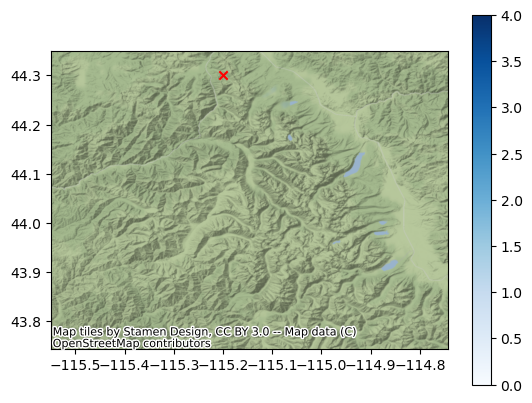

In [9]:
fig, ax = plt.subplots()
ds.isel(time = 0, x = slice(0, -1, 100), y = slice(0, -1, 100)).plot(ax = ax, alpha = 0, add_colorbar = False)
im = plt.imshow([[1,1],[1,1]], vmax = 4, vmin = 0, cmap = 'Blues')
plt.colorbar(im)
ctx.add_basemap(ax = ax, crs = 'EPSG:4326')
# sac_sussex[sac_sussex.SHAPE_Leng > 0.001].plot(ax = ax, color = 'black')
plt.title('')
plt.xlabel('')
plt.ylabel('')
ax.scatter(-115.2, 44.3, color = 'red', zorder = 1e6, marker = 'x')

plt.savefig(gif_dir.joinpath('stanley_map.png'))

In [10]:
gif(ds.where(ds.relative_orbit != 20), fps = 3, cmap = 'Blues', vmin = 0, vmax = 4, to = gif_dir.joinpath('stanley.gif')) # to = gif_dir.joinpath(loc + '.gif')

# snotel

In [11]:
snotel = pd.read_csv('/bsuhome/zacharykeskinen/spicy-analysis/results/312_STAND_WATERYEAR=2021.csv', skiprows = 4, parse_dates = ['Date'])
snotel['sd'] = snotel['SNWD.I-1 (in) ']* 0.0254
snotel = snotel.set_index('Date')
snotel = snotel.loc[slice(pd.to_datetime(ds.time.min().data), pd.to_datetime(ds.time.max().data))]

In [12]:
snotel_spicy = ds.where(ds.relative_orbit != 20).loc[{'x': slice(-115.24, -115.225), 'y': slice(44.32, 44.285)}].mean(['x', 'y'])
ds_df = snotel_spicy.to_dataframe()['snow_depth'].dropna()
ds_df.index = pd.to_datetime(ds_df.index.strftime('%Y-%m-%d'))

snotel['spicy'] = np.nan

for i, r in ds_df.items():
    snotel.loc[i, 'spicy'] = r

In [13]:
import gif

@gif.frame
def helper_plot_1(df, i):
    df = df.copy()
    df.iloc[i:] = np.nan
    ax = df['sd'].plot(legend=False, style="o--", label = 'Snotel', figsize = (20, 6), linewidth = 5)
    plt.title("Banner Summit Snotel", fontsize = 28)
    df['spicy'].dropna().plot(ax = ax, label = 'Retrieved', marker = 'x', color = 'black', linewidth = 5)
    ax.set_xlabel("")
    ax.set_ylabel("Snow Depth", fontsize = 24)
    ax.set_xlim(df.index[0], df.index[-1])
    ax.set_xticks([pd.to_datetime(t) for t in ['2021-02-01', '2020-12-01', '2020-10-01']], ['2021-02-01', '2020-12-01', '2020-10-01'], fontsize = 20)
    ax.set_yticks([0, 0.5, 1, 1.5, 2],[0, 0.5, 1, 1.5, 2], fontsize = 20)
    ax.set_ylim(-0.1, 2.1)
    plt.legend(loc = 'upper left', fontsize = 24)
    plt.tight_layout()

In [14]:
frames = []
for i in range(1, len(snotel)):
    frames.append(helper_plot_1(snotel.sort_index(), i))

In [15]:
fps = len(ds.where(ds.relative_orbit != 20).time) / len(frames) * 333.333333333
gif.save(frames, str(gif_dir.joinpath('snotel.gif')), 
         duration=fps)

In [20]:
ds.isel(time = 90).rio.to_raster(Path('~/test.tiff').expanduser())